<a href="https://colab.research.google.com/github/mmoh-i/House-Price-Prediction-In-Nigeria/blob/main/DSN_HACK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Google Drive

In [33]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/DSNHack2023')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
 %%capture
 !pip install catboost

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, plot_importance
from matplotlib import pyplot
from sklearn.feature_selection import mutual_info_regression, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV,Lasso,Ridge,RidgeCV,ElasticNet
from catboost import CatBoostRegressor

#Importing Packages
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

In [36]:
seed=0

In [37]:
import pandas as pd

df_train = pd.read_csv('/content/drive/MyDrive/DSNHack2023/Housing_dataset_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/DSNHack2023/Housing_dataset_test.csv')
df_sub = pd.read_csv('/content/drive/MyDrive/DSNHack2023/Sample_submission.csv')

df_train.head()

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [38]:
df_train.info()
print(f"Train data shape: {df_train.shape}, Test data shape: {df_test.shape}, submission dataset{df_sub.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             14000 non-null  int64  
 1   loc            12187 non-null  object 
 2   title          12278 non-null  object 
 3   bedroom        12201 non-null  float64
 4   bathroom       12195 non-null  float64
 5   parking_space  12189 non-null  float64
 6   price          14000 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 765.8+ KB
Train data shape: (14000, 7), Test data shape: (6000, 6), submission dataset(6000, 1)


In [39]:
df_train_ = df_train.dropna(subset=["bedroom","bathroom","parking_space"]).reset_index(drop=True)

df_train = df_train.dropna(thresh=6).reset_index(drop=True)

In [40]:
#save and drop id
train_id = df_train["ID"]
df_train.drop(columns='ID',inplace=True)

test_id = df_test["ID"]
df_test.drop(columns='ID',inplace=True)

#select object columns
obj_col = df_train.columns[df_train.dtypes == 'object'].values

#selecting the non object columns
num_col = df_train.columns[df_train.dtypes != 'object'].values
num_col_test = df_test.columns[df_test.dtypes != 'object'].values

#filling  null values in obj columns with None
df_train[obj_col] = df_train[obj_col].fillna('None')
df_test[obj_col] = df_test[obj_col].fillna('None')

#filling the numeric columns with 0
df_train[num_col] = df_train[num_col].fillna(0)
df_test[num_col_test] = df_test[num_col_test].fillna(0)

train_001 = df_train
test_001 = df_test

In [41]:
df_train.head()

,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,Ondo,Apartment,0.0,2.0,4.0,1672416.689
2,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
3,Kogi,Terrace duplex,0.0,5.0,6.0,2600700.898
4,Borno,Mansion,0.0,1.0,3.0,1341750.867


In [42]:
## some EDA

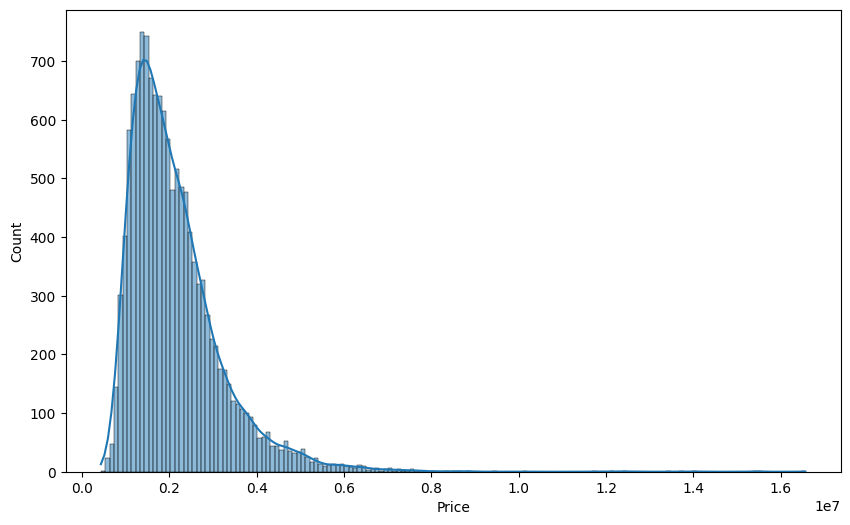

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train["price"], kde=True)
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

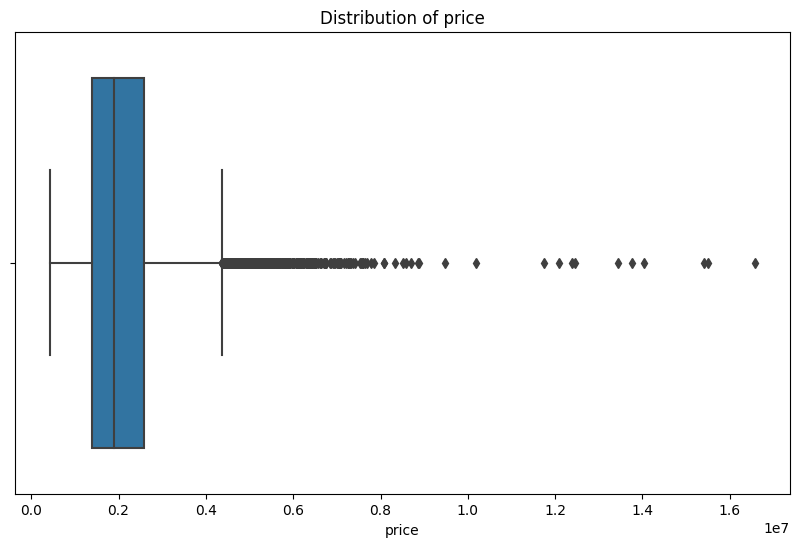

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x= df_train["price"])
plt.title("Distribution of price")
plt.show()

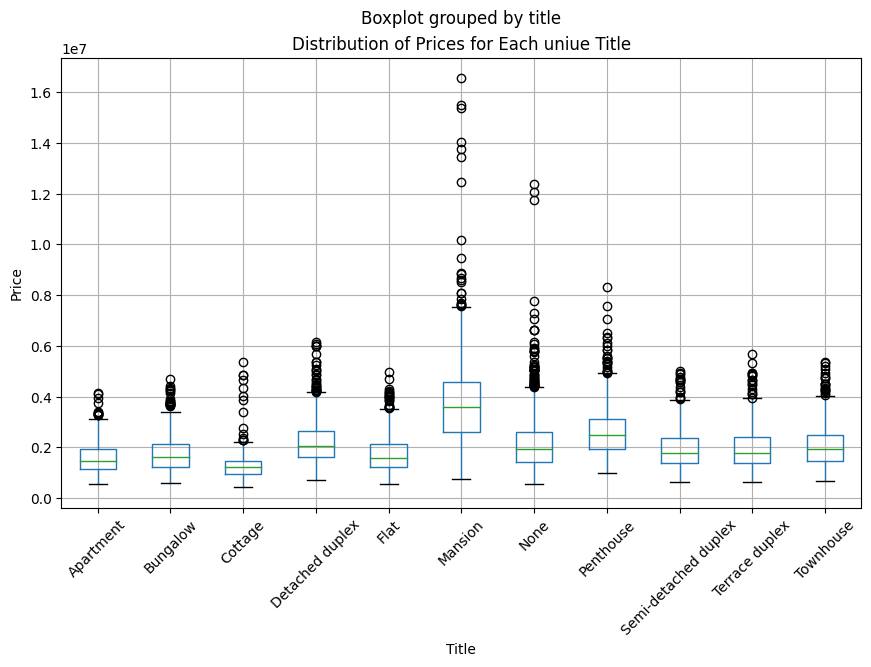

In [45]:
df_train.boxplot(column= 'price', by='title', figsize=(10, 6))
plt.xlabel('Title')
plt.ylabel('Price')
plt.title('Distribution of Prices for Each uniue Title')
plt.xticks(rotation=45)
plt.show()

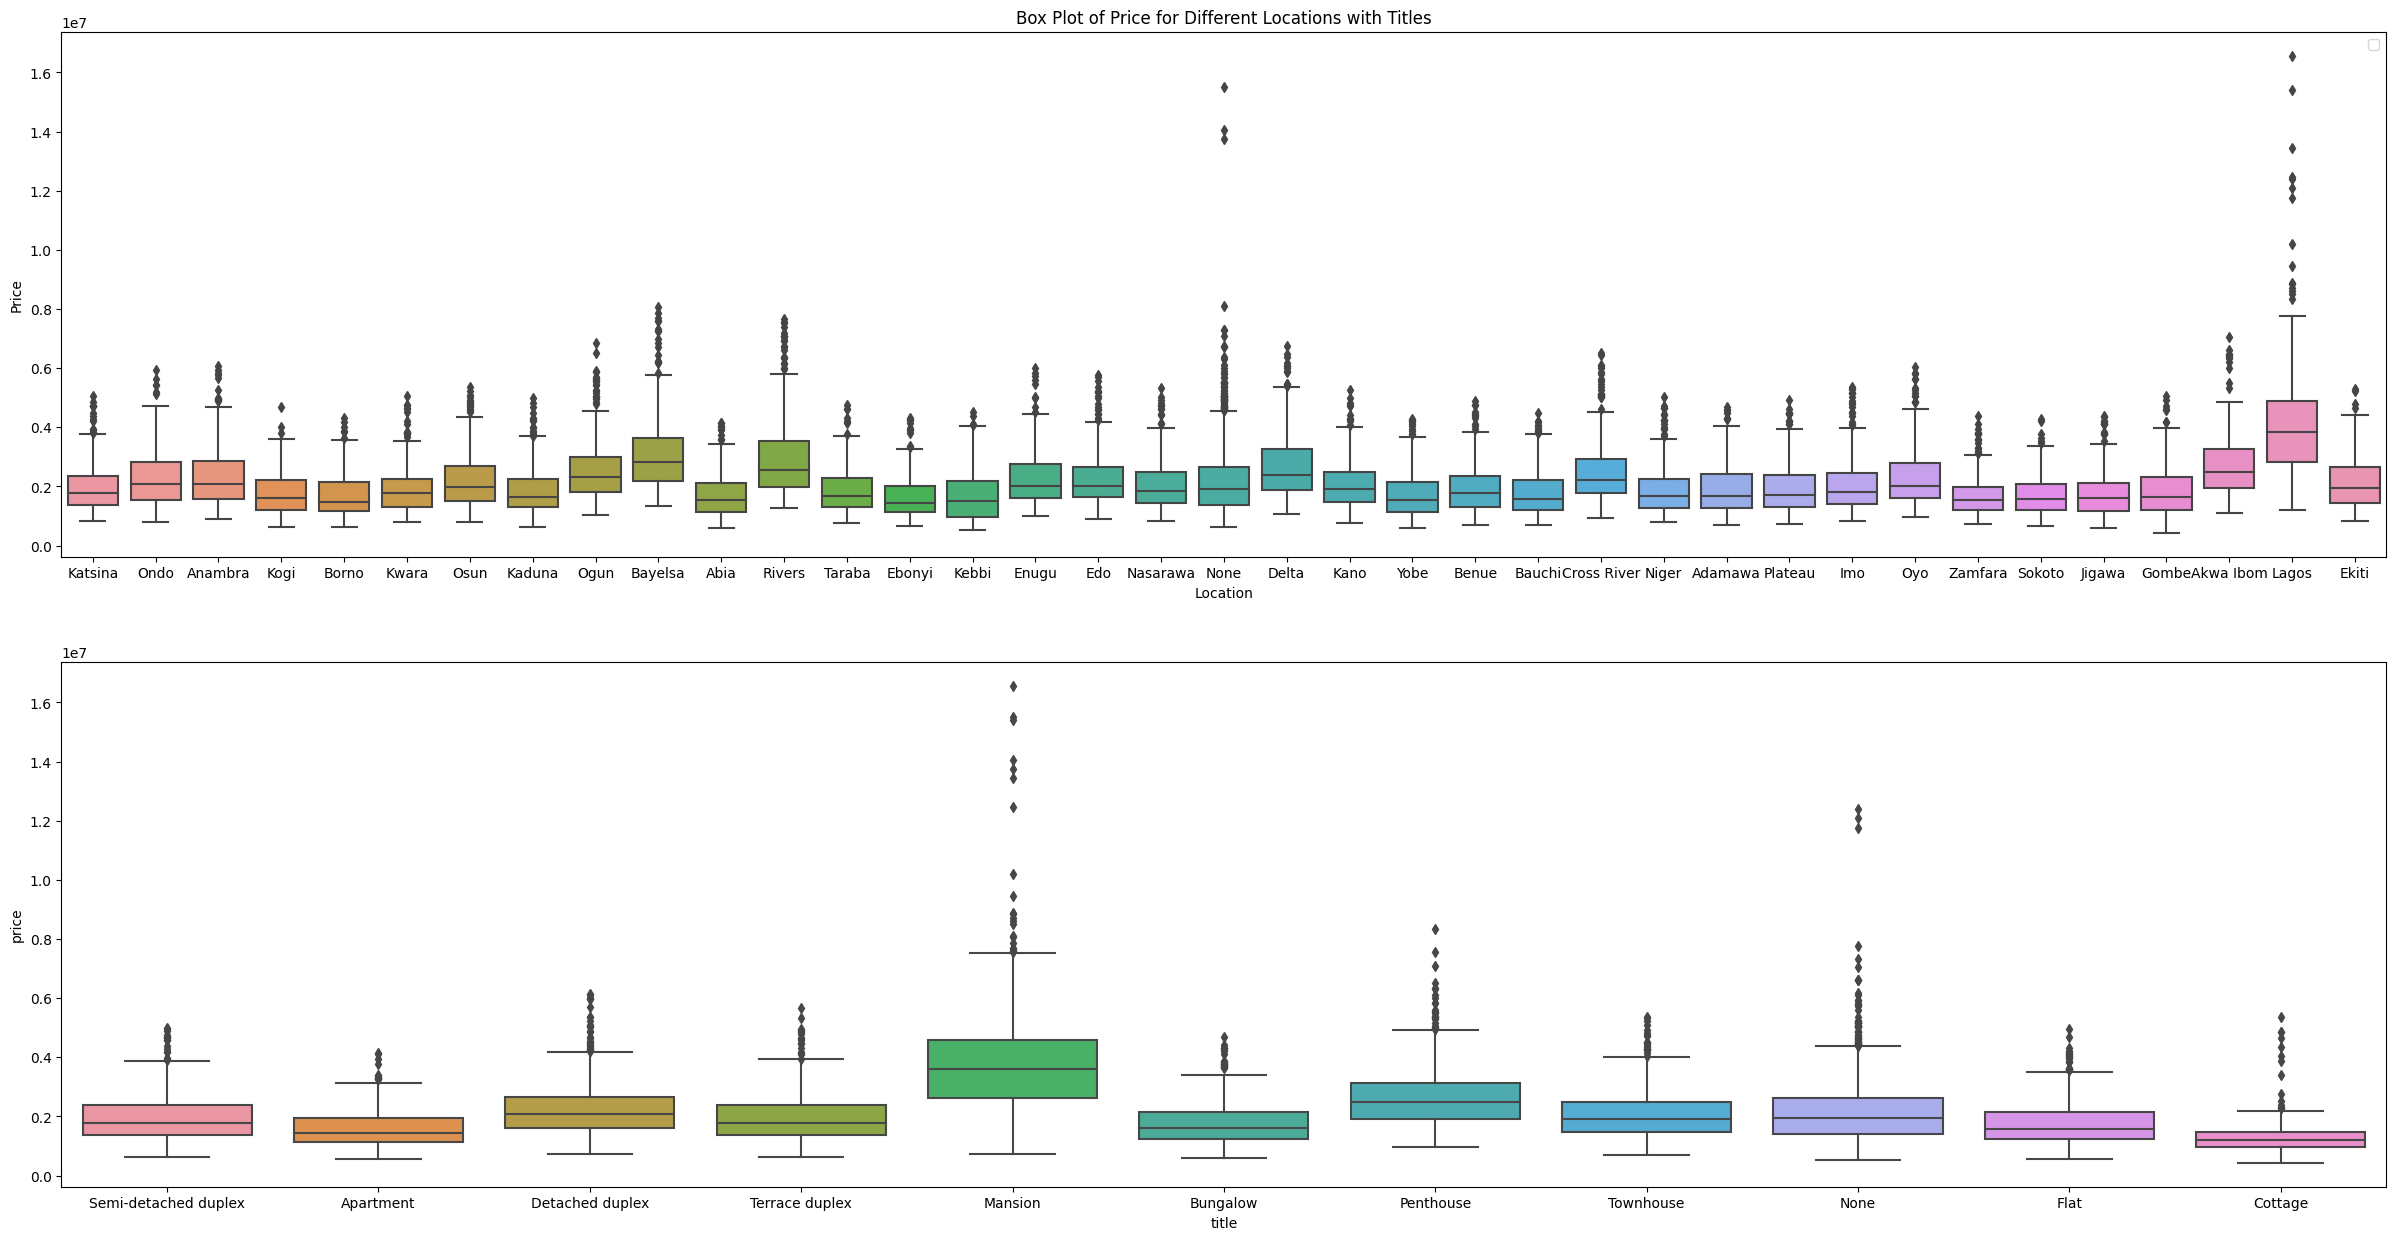

In [46]:
plt.figure(figsize=(30, 15))
plt.subplot(2, 1, 1)
sns.boxplot(x = 'loc' , y = 'price',data=df_train)
plt.xlabel('Location')
plt.ylabel('Price')
plt.title('Box Plot of Price for Different Locations with Titles')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
sns.boxplot(x='title', y='price', data=df_train)
plt.show()

In [47]:
for col in ["loc", "title"]:
  mapper = df_train.groupby(col)["price"].agg("mean").to_dict()

  df_train[f"{col}_avg"] = df_train[col].map(mapper)
  df_test[f"{col}_avg"] = df_test[col].map(mapper)

In [48]:
df_train.head()

,loc,title,bedroom,bathroom,parking_space,price,loc_avg,title_avg
0,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565,1.951144e+06,1.921138e+06
1,Ondo,Apartment,0.0,2.0,4.0,1672416.689,2.270298e+06,1.569751e+06
2,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756,2.344395e+06,2.208195e+06
3,Kogi,Terrace duplex,0.0,5.0,6.0,2600700.898,1.762723e+06,1.931085e+06
4,Borno,Mansion,0.0,1.0,3.0,1341750.867,1.738409e+06,3.726426e+06


In [49]:
#test.head()

In [50]:
#Encoding

categorical_cols = ['loc','title']


encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
dummy_df = pd.DataFrame(encoder.fit_transform((df_train[categorical_cols])))
dummy_df.index = df_train.index
dummy_df.columns = encoder.get_feature_names_out(categorical_cols)

df_train.drop(categorical_cols,axis=1,inplace = True)
train = pd.concat([df_train,dummy_df],axis=1)


#Test sef Encoding
dummy_df = pd.DataFrame(encoder.transform((df_test[categorical_cols])))
dummy_df.index = df_test.index
dummy_df.columns = encoder.get_feature_names_out(categorical_cols)

df_test.drop(categorical_cols,axis=1,inplace = True)
test= pd.concat([df_test,dummy_df],axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [51]:
print(f"Test shape: {test.shape}, Train shape: {train.shape}")

Test shape: (6000, 53), Train shape: (13420, 54)


In [52]:
#TotalBath
train['Totalrooms'] = (train['bedroom'] + train['bathroom'])
test['Totalrooms']  = (test['bedroom']  + test['bathroom'])

train['PSBinary'] = train['parking_space'].apply(lambda x: 1 if x > 3 else 0)
test['PSBinary']  = test['parking_space'].apply(lambda x: 1 if x > 3 else 0)

train['bathroomBinary'] = train['bathroom'].apply(lambda x: 1 if x > 3 else 0)
test['bathroomBinary']  = test['bathroom'].apply(lambda x: 1 if x > 3 else 0)

train['bedroomBinary'] = train['bedroom'].apply(lambda x: 1 if x > 5 else 0)
test['bedroomBinary']  = test['bedroom'].apply(lambda x: 1 if x > 5 else 0)

In [53]:
test.head()

,bedroom,bathroom,parking_space,loc_avg,title_avg,loc_Abia,loc_Adamawa,loc_Akwa Ibom,loc_Anambra,loc_Bauchi,...,title_Mansion,title_None,title_Penthouse,title_Semi-detached duplex,title_Terrace duplex,title_Townhouse,Totalrooms,PSBinary,bathroomBinary,bedroomBinary
0,4,1,2,2.084425e+06,2.625518e+06,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,5,0,0,0
1,2,2,4,1.891712e+06,1.569751e+06,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,1,0,0
2,2,7,2,1.891712e+06,1.731570e+06,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9,0,1,0
3,9,5,2,4.174026e+06,3.726426e+06,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,14,0,1,1
4,5,6,1,1.856344e+06,1.921138e+06,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,11,0,1,0


In [54]:
train.head()

,bedroom,bathroom,parking_space,price,loc_avg,title_avg,loc_Abia,loc_Adamawa,loc_Akwa Ibom,loc_Anambra,...,title_Mansion,title_None,title_Penthouse,title_Semi-detached duplex,title_Terrace duplex,title_Townhouse,Totalrooms,PSBinary,bathroomBinary,bedroomBinary
0,2.0,2.0,1.0,1149999.565,1.951144e+06,1.921138e+06,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0,0,0
1,0.0,2.0,4.0,1672416.689,2.270298e+06,1.569751e+06,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1,0,0
2,5.0,2.0,4.0,2410306.756,2.344395e+06,2.208195e+06,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1,0,0
3,0.0,5.0,6.0,2600700.898,1.762723e+06,1.931085e+06,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,5.0,1,1,0
4,0.0,1.0,3.0,1341750.867,1.738409e+06,3.726426e+06,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0


In [55]:
train.isna().sum()

bedroom                       0
bathroom                      0
parking_space                 0
price                         0
loc_avg                       0
title_avg                     0
loc_Abia                      0
loc_Adamawa                   0
loc_Akwa Ibom                 0
loc_Anambra                   0
loc_Bauchi                    0
loc_Bayelsa                   0
loc_Benue                     0
loc_Borno                     0
loc_Cross River               0
loc_Delta                     0
loc_Ebonyi                    0
loc_Edo                       0
loc_Ekiti                     0
loc_Enugu                     0
loc_Gombe                     0
loc_Imo                       0
loc_Jigawa                    0
loc_Kaduna                    0
loc_Kano                      0
loc_Katsina                   0
loc_Kebbi                     0
loc_Kogi                      0
loc_Kwara                     0
loc_Lagos                     0
loc_Nasarawa                  0
loc_Nige

In [56]:
#Importing packages
from sklearn.model_selection import train_test_split

X = train.drop(columns="price")
y = train["price"]


X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size=0.25,random_state=seed)

In [57]:
X_train.shape, X_test.shape

((10065, 57), (3355, 57))

In [58]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [5, 7],#3, #, 10
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [59]:
#Run only in the first run of the kernel.
#hyperParameterTuning(X_train, y_train)

In [60]:
#function to return RootMeanSuared Error
def rmse(X,y):
  return np.sqrt(mean_squared_error(X,y))

In [61]:
class CFG:

  xgb_param1 = {'colsample_bytree': 0.5,   ## 348865.0752
              'learning_rate': 0.1,
              'max_depth': 5,
              'min_child_weight': 3,
              'n_estimators': 200,
              'objective': 'reg:squarederror',
              'subsample': 0.7}

  xgb_param2 = {"booster":'gbtree', "colsample_bytree":0.8, "eta":0.3, "eval_metric":'rmse',    ## 343720.9578
              "gamma":0.3,  "max_depth":2, "min_child_weight":4,  "n_estimators":500}

  xgb_param3 = {"booster":'gbtree', "colsample_bytree":0.8, "eta":0.3, "eval_metric":'rmse',  ## 345824.0014
              "gamma":0.3,  "max_depth":5, "min_child_weight":4,  "n_estimators":200,
              'learning_rate': 0.1,
              'objective': 'reg:squarederror',
              'subsample': 0.7}

  cat_param1 = {'depth': 6, 'iterations': 50, 'l2_leaf_reg': 6, 'learning_rate': 0.5}  ## 344998.3072

  rf_param1 = {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': True}

  lgb_param = {'bagging_fraction': 0.8, 'bagging_freq': 200, 'boosting': 'gbdt', 'feature_fraction': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'min_data_in_leaf': 15,
               'num_iterations': 1000, 'num_leaves': 7, 'objective': 'root_mean_squared_error', 'task': 'predict'}

  lgb_param2 = {'learning_rate': 0.03,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        "subsample": 0.99,
        "colsample_bytree": 0.99,
        "random_state":42,
        'max_depth': 15,
        'lambda_l2': 0.02085548700474218,
        'lambda_l1': 0.004107624022751344,
        'bagging_fraction': 0.7934712636944741,
        'feature_fraction': 0.686612409641711,
        'min_child_samples': 21
       }

**Ensemble**

In [62]:
xgb1 = XGBRegressor(
        **CFG.xgb_param1, random_state=47)

xgb2 = XGBRegressor(
        **CFG.xgb_param2, random_state=47)

xgb3 = XGBRegressor(
        **CFG.xgb_param3, random_state=47)

cat = CatBoostRegressor(**CFG.cat_param1, random_state=47)

rf = RandomForestRegressor(**CFG.rf_param1 , random_state=47)

lgb_model1 = lgb.LGBMRegressor(
    task = 'predict',
    application = 'regression',
    objective = 'root_mean_squared_error',
    boosting_type="gbdt",
    num_iterations = 1000,
    learning_rate = 0.07,
    num_leaves=15,
    tree_learner='feature',
    max_depth =10,
    min_data_in_leaf=7,
    bagging_fraction = 1,
    bagging_freq = 100,
    reg_sqrt='True',
    metric ='rmse',
    feature_fraction = 0.6,
    random_state=42)

lgb_model2 = lgb.LGBMRegressor(**CFG.lgb_param, random_state=47)

lgb_model3  = lgb.LGBMRegressor(**CFG.lgb_param2,
         n_estimators=1000
    )

models = [('xgb1',xgb1),('xgb2',xgb2),('xgb3',xgb3),("cat",cat),("rf",rf),("lgb_model1",lgb_model1),("lgb_model2",lgb_model2),("lgb_model3",lgb_model3)]

ensemble = VotingRegressor(estimators=models, weights=[2,1,3,1,1,3,1,2])
ensemble.fit(X, np.log1p(y))

0:	learn: 0.3180298	total: 49.9ms	remaining: 2.44s
1:	learn: 0.2546369	total: 52.6ms	remaining: 1.26s
2:	learn: 0.2199838	total: 55.3ms	remaining: 867ms
3:	learn: 0.2028361	total: 57.9ms	remaining: 666ms
4:	learn: 0.1953648	total: 60.4ms	remaining: 543ms
5:	learn: 0.1884274	total: 62.9ms	remaining: 461ms
6:	learn: 0.1864286	total: 65.9ms	remaining: 405ms
7:	learn: 0.1845097	total: 70.6ms	remaining: 371ms
8:	learn: 0.1834438	total: 76.7ms	remaining: 349ms
9:	learn: 0.1827618	total: 79ms	remaining: 316ms
10:	learn: 0.1820332	total: 81.3ms	remaining: 288ms
11:	learn: 0.1811173	total: 83.6ms	remaining: 265ms
12:	learn: 0.1805408	total: 85.8ms	remaining: 244ms
13:	learn: 0.1799506	total: 88.1ms	remaining: 227ms
14:	learn: 0.1796170	total: 90.5ms	remaining: 211ms
15:	learn: 0.1790063	total: 92.8ms	remaining: 197ms
16:	learn: 0.1784356	total: 95.2ms	remaining: 185ms
17:	learn: 0.1782226	total: 96.9ms	remaining: 172ms
18:	learn: 0.1776880	total: 99.2ms	remaining: 162ms
19:	learn: 0.1772011	tot

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.004107624022751344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004107624022751344
[LightGBM] [Warning] bagging_fraction is set=0.7934712636944741, subsample=0.99 will be ignored. Current value: bagging_fraction=0.7934712636944741
[LightGBM] [Warning] feature_fraction is set=0.686612409641711, colsample_bytree=0.99 will be ignored. Current value: feature_fraction=0.686612409641711
[LightGBM] [Warning] lambda_l2 is set=0.02085548700474218, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02085548700474218
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing w

VotingRegressor(estimators=[('xgb1',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.5,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                            ('lgb_model3',
                             LGBMRegressor(bagging_fraction=0.7934712636944741,
                                           colsample_bytree=0.99,
                                           feature_fraction=0.686612409641711,
                                           lambda_l1=0.004107624022751344,
                                           lambda_l2=0.02085548700474218,
                                           learning_rate=0.03, max_depth=15,
                                           metric='rmse', min_child_samples=21,
                                           n_estimators=1000,
                                           objective='regression',
                                           random_state=42, subsample=0.99,
                                           verbose=1))],
                weights=[2, 1, 3, 1, 1, 3, 1, 2])

In [63]:


# mse = mean_squared_error(y_test, ensemble_predictions)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, ensemble_predictions)


# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R-squared (R2): {r2:.2f}")

In [64]:
sub = pd.DataFrame({"ID":test_id, "price":np.exp(ensemble.predict(test))})
# sub_df['price'] = sub_df['price'].apply(lambda x: "{:.3f}".format(x))
sub.to_csv("submission.csv", index=False)
sub.head()

,ID,price
0,845,2.354687e+06
1,1924,1.033753e+06
2,10718,1.250667e+06
3,12076,8.696877e+06
4,12254,1.849953e+06


In [65]:
# check_model = ensemble.fit(X_train, y_train)
# preds = check_model.predict(X_test)


In [67]:
# plt.scatter(y_test, preds, alpha=0.5)
# plt.xlabel("True Values")
# plt.ylabel("Predicted Values")
# plt.title("True Values vs. Predicted Values")

# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.show()